In [4]:
#imports

import numpy as np
import shelve
from astropy.table import QTable
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from astropy.table import QTable
import os
import math
import shutil
from IPython.core.debugger import Tracer
import subprocess
import re
%matplotlib inline

In [5]:
ic = QTable.read('IC_table.csv',format='ascii.csv')
sim_idx = ic['Sim #']
dMass_b = ic['Mass_b']
dMass_c = ic['Mass_c']
dRadius_b = ic['Radius_b']
dRadius_c = ic['Radius_c']
dSemi_b = ic['Semi_b_0']
dSemi_c = ic['Semi_c_0']
dEcc_b = ic['Ecc_b_0']
dEcc_c = ic['Ecc_c_0']
dInc_b = ic['Incl_b_0']
dInc_c = ic['Incl_c_0']
dLongA_b = ic['LongA_b_0']
dLongA_c = ic['LongA_c_0']
dArgP_b = ic['ArgP_b_0']
dArgP_c = ic['ArgP_c_0']
dTidalQ_b = ic['Qp_b']
dTidalQ_c = ic['Qp_c']
dTidalQ_star = ic['Q_star']
dMass_star = ic['Mass_star']
dRadius_star = ic['Radius_star']

In [15]:
# picks out earthlike inner, circ inner, close-in inner, close-in outer
# picked 00857

selection_mask = np.where((np.abs(dMass_b)<=1) & (dEcc_b <= 0.01) & (dSemi_b <= 0.1) & (dSemi_c <= 1))
ic[857]

Sim #,Mass_b,Mass_c,Radius_b,Radius_c,Semi_b_0,Semi_c_0,Ecc_b_0,Ecc_c_0,Incl_b_0,Incl_c_0,LongA_b_0,LongA_c_0,ArgP_b_0,ArgP_c_0,Qp_b,Qp_c,Q_star,Mass_star,Radius_star
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
857.0,-0.939770900815,-16.8767782348,-0.98326146697,-4.52688840489,0.0367296251244,0.304380737188,0.00443119135111,0.158676336859,0.0,2.5903491442,106.132404193,287.909978502,342.836478148,144.298131559,88.7026249324,4289070.34084,2317458.86215,1.19191866025,0.00572120956918


In [32]:
# now to compare a and e for each san_check case w/ eqonly case (00857)
san_check_dir = '/home/dm1681/Research/Research/Merging_Perts/comp_san_check/'
s_mass_list = ['nep','sup_ear']
s_res_list = ['long','short']
s_ecc_list = ['circ','ecc']

# this script fills the below arrays
# eq_* --> eqtide only runs, similarly for eqorb_* referring to eqtide + distorb
# *_short or *_long refers to the resolution
eq_short_time = np.array([])
eq_long_time = np.array([])
eq_short_semi = np.array([])
eq_long_semi = np.array([])
eq_short_e = np.array([])
eq_long_e = np.array([])



# pulls eqtide data
for res in s_res_list:
    b_fwd = open(san_check_dir+'00857_'+res+'_eq'+'/system.b.forward') # forward file
    b_fwd_content = b_fwd.read()
    b_fwd_content = b_fwd_content.split('\n')
    b_fwd_content = b_fwd_content[:-1] # removes the last line, which is just an empty array
    for line in b_fwd_content:
        items = line.split(' ')
        time = items[0]
        semi = items[1]
        e = items[2]
        #print(time)
        if res == 'long':
            eq_long_time = np.append(eq_long_time, time)
            eq_long_semi = np.append(eq_long_semi, semi)
            eq_long_e = np.append(eq_long_e, e)
        elif res == 'short':
            eq_short_time = np.append(eq_short_time, time)
            eq_short_semi = np.append(eq_short_semi, semi)
            eq_short_e = np.append(eq_short_e, e)

            
            
#sup_ear data
sup_ear_short_ecc_time = np.array([])
sup_ear_long_ecc_time = np.array([])
sup_ear_short_ecc_semi = np.array([])
sup_ear_long_ecc_semi = np.array([])
sup_ear_short_ecc_e = np.array([])
sup_ear_long_ecc_e = np.array([])

sup_ear_short_circ_time = np.array([])
sup_ear_long_circ_time = np.array([])
sup_ear_short_circ_semi = np.array([])
sup_ear_long_circ_semi = np.array([])
sup_ear_short_circ_e = np.array([])
sup_ear_long_circ_e = np.array([])

#nep data
nep_short_ecc_time = np.array([])
nep_long_ecc_time = np.array([])
nep_short_ecc_semi = np.array([])
nep_long_ecc_semi = np.array([])
nep_short_ecc_e = np.array([])
nep_long_ecc_e = np.array([])

nep_short_circ_time = np.array([])
nep_long_circ_time = np.array([])
nep_short_circ_semi = np.array([])
nep_long_circ_semi = np.array([])
nep_short_circ_e = np.array([])
nep_long_circ_e = np.array([])
            
# pulls eqorb data
for mass_c in s_mass_list:
    for res in s_res_list:
        for ecc in s_ecc_list:
            run_dir = san_check_dir+mass_c+'_'+res+'_'+ecc
            b_fwd = open(run_dir+'/system.b.forward')
            b_fwd_content = b_fwd.read()
            b_fwd_content = b_fwd_content.split('\n')
            b_fwd_content = b_fwd_content[:-1]
            for line in b_fwd_content:
                items = line.split(' ')
                time = items[0]
                semi = items[1]
                e = items[2]
                # sorts the above pulled data based on resolution and mass_c
                if res == 'long':
                    if mass_c == 'sup_ear':
                        if ecc == 'ecc':
                            sup_ear_long_ecc_time = np.append(sup_ear_long_ecc_time, time)
                            sup_ear_long_ecc_semi = np.append(sup_ear_long_ecc_semi, semi)
                            sup_ear_long_ecc_e = np.append(sup_ear_long_ecc_e, e)
                        elif ecc == 'circ':
                            sup_ear_long_circ_time = np.append(sup_ear_long_circ_time, time)
                            sup_ear_long_circ_semi = np.append(sup_ear_long_circ_semi, semi)
                            sup_ear_long_circ_e = np.append(sup_ear_long_circ_e, e)
                    elif mass_c == 'nep':
                        if ecc == 'ecc':
                            nep_long_ecc_time = np.append(nep_long_ecc_time, time)
                            nep_long_ecc_semi = np.append(nep_long_ecc_semi, semi)
                            nep_long_ecc_e = np.append(nep_long_ecc_e, e)
                        elif ecc == 'circ':
                            nep_long_circ_time = np.append(nep_long_circ_time, time)
                            nep_long_circ_semi = np.append(nep_long_circ_semi, semi)
                            nep_long_circ_e = np.append(nep_long_circ_e, e)
                    
                elif res == 'short':
                    if mass_c == 'sup_ear':
                        if ecc == 'ecc':
                            sup_ear_short_ecc_time = np.append(sup_ear_short_ecc_time, time)
                            sup_ear_short_ecc_semi = np.append(sup_ear_short_ecc_semi, semi)
                            sup_ear_short_ecc_e = np.append(sup_ear_short_ecc_e, e)
                        elif ecc == 'circ':
                            sup_ear_short_circ_time = np.append(sup_ear_short_circ_time, time)
                            sup_ear_short_circ_semi = np.append(sup_ear_short_circ_semi, semi)
                            sup_ear_short_circ_e = np.append(sup_ear_short_circ_e, e)
                    elif mass_c == 'nep':
                        if ecc == 'ecc':
                            nep_short_ecc_time = np.append(nep_short_ecc_time, time)
                            nep_short_ecc_semi = np.append(nep_short_ecc_semi, semi)
                            nep_short_ecc_e = np.append(nep_short_ecc_e, e)
                        elif ecc == 'circ':
                            nep_short_circ_time = np.append(nep_short_circ_time, time)
                            nep_short_circ_semi = np.append(nep_short_circ_semi, semi)
                            nep_short_circ_e = np.append(nep_short_circ_e, e)
            




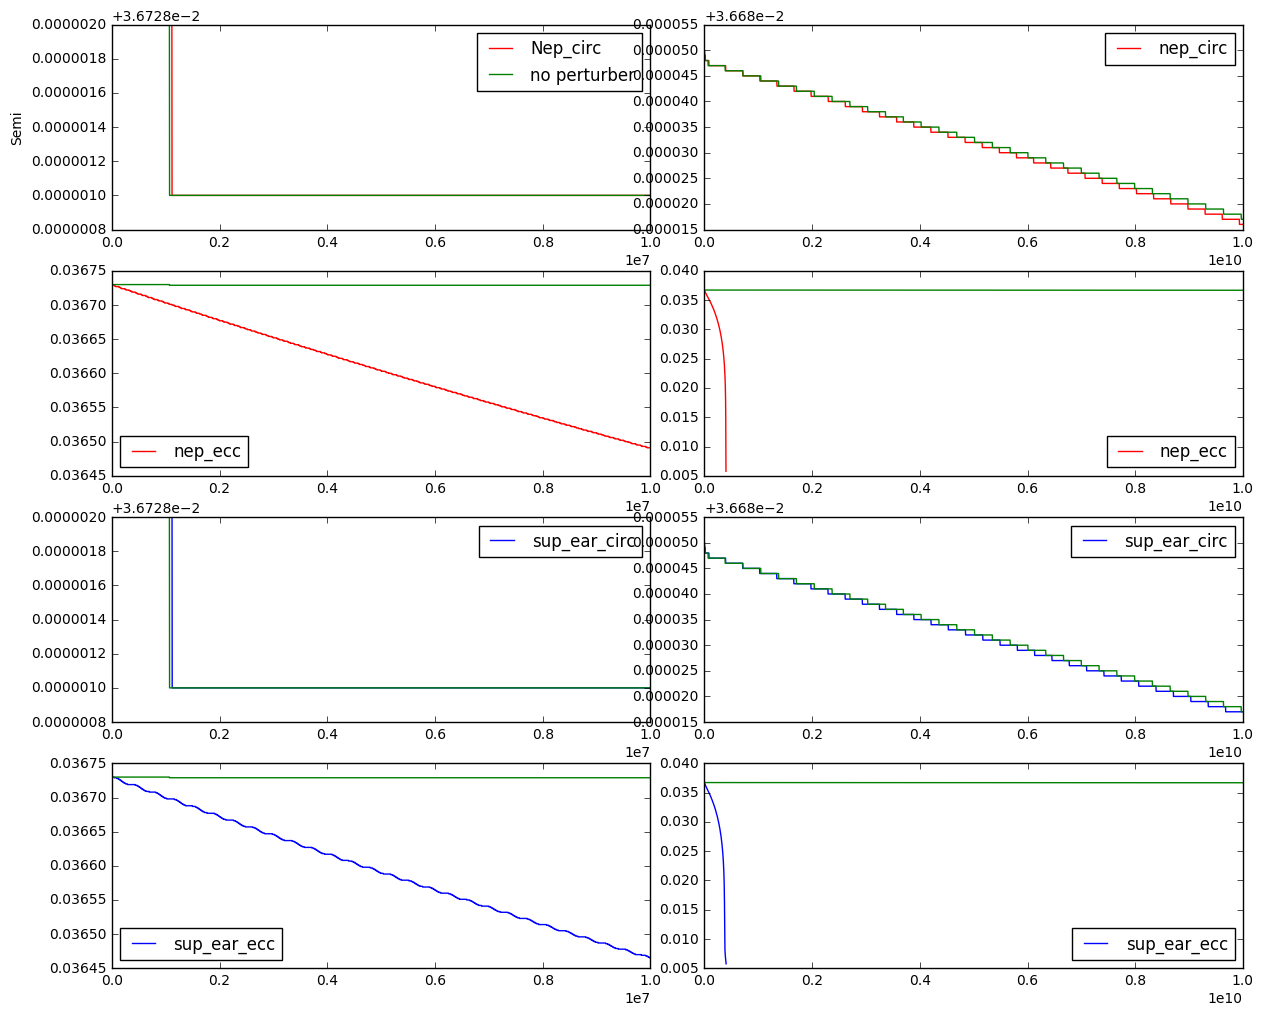

In [63]:
# plots the evolution of the semi major axis for all cases, and compares with unperturbed cases (eq_only)

fig,ax = plt.subplots(4,2)
fig.set_size_inches(12,10)
plt.tight_layout()
plt.ticklabel_format(axis = 'y', style = 'sci')
# green is always eq_only (no perturber)
# red is neptune mass perturber
# blue is super earth mass perturber

# plots semi
ax[0,0].plot(nep_short_circ_time, nep_short_circ_semi, color = 'red', label = 'Nep_circ')
ax[0,0].plot(eq_short_time, eq_short_semi, color = 'green', label = 'no perturber')

ax[0,1].plot(nep_long_circ_time, nep_long_circ_semi, color = 'red', label = 'nep_circ')
ax[0,1].plot(eq_long_time, eq_long_semi, color = 'green')

ax[1,0].plot(nep_short_ecc_time, nep_short_ecc_semi, color = 'red', label = 'nep_ecc')
ax[1,0].plot(eq_short_time, eq_short_semi, color = 'green')

ax[1,1].plot(nep_long_ecc_time, nep_long_ecc_semi, color = 'red', label = 'nep_ecc')
ax[1,1].plot(eq_long_time, eq_long_semi, color = 'green')

ax[2,0].plot(sup_ear_short_circ_time, sup_ear_short_circ_semi, color = 'blue', label = 'sup_ear_circ')
ax[2,0].plot(eq_short_time, eq_short_semi, color = 'green')

ax[2,1].plot(sup_ear_long_circ_time, sup_ear_long_circ_semi, color = 'blue', label = 'sup_ear_circ')
ax[2,1].plot(eq_long_time, eq_long_semi, color = 'green')

ax[3,0].plot(sup_ear_short_ecc_time, sup_ear_short_ecc_semi, color = 'blue', label = 'sup_ear_ecc')
ax[3,0].plot(eq_short_time, eq_short_semi, color = 'green')

ax[3,1].plot(sup_ear_long_ecc_time, sup_ear_long_ecc_semi, color = 'blue', label = 'sup_ear_ecc')
ax[3,1].plot(eq_long_time, eq_long_semi, color = 'green')

ax[0,0].legend(loc=0)
ax[0,1].legend(loc=0)
ax[1,0].legend(loc=0)
ax[1,1].legend(loc=0)
ax[2,0].legend(loc=0)
ax[2,1].legend(loc=0)
ax[3,0].legend(loc=0)
ax[3,1].legend(loc=0)
ax[0,0].set_ylabel('Semi')

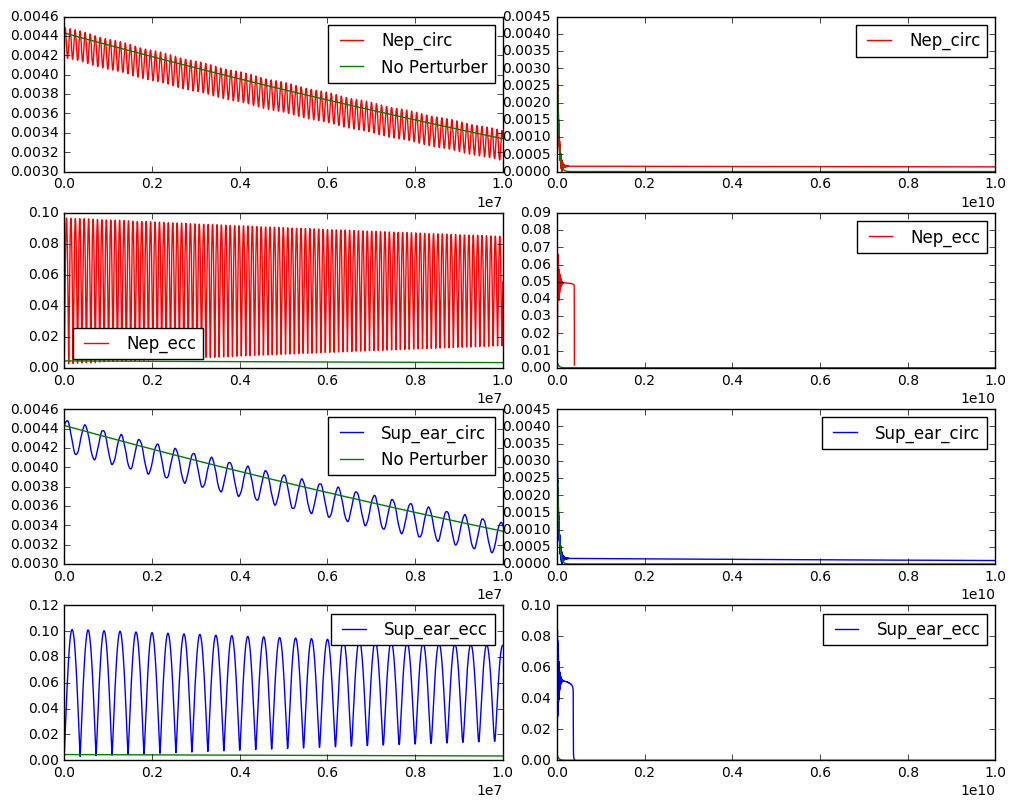

In [62]:
# plots the evolution of the semi major axis for all cases, and compares with unperturbed cases (eq_only)

fig,ax = plt.subplots(4,2)
fig.set_size_inches(10,8)
plt.tight_layout()
plt.ticklabel_format(axis = 'y', style = 'sci')
# green is always eq_only (no perturber)
# red is neptune mass perturber
# blue is super earth mass perturber

ax[0,0].plot(nep_short_circ_time, nep_short_circ_e, color = 'red', label = 'Nep_circ')
ax[0,0].plot(eq_short_time, eq_short_e, color = 'green', label = 'No Perturber')

ax[0,1].plot(nep_long_circ_time, nep_long_circ_e, color = 'red', label = 'Nep_circ')
ax[0,1].plot(eq_long_time, eq_long_e, color = 'green')

ax[1,0].plot(nep_short_ecc_time, nep_short_ecc_e, color = 'red', label = 'Nep_ecc')
ax[1,0].plot(eq_short_time, eq_short_e, color = 'green')

ax[1,1].plot(nep_long_ecc_time, nep_long_ecc_e, color = 'red', label = 'Nep_ecc')
ax[1,1].plot(eq_long_time, eq_long_e, color = 'green')

ax[2,0].plot(sup_ear_short_circ_time, sup_ear_short_circ_e, color = 'blue', label = 'Sup_ear_circ')
ax[2,0].plot(eq_short_time, eq_short_e, color = 'green', label = 'No Perturber')

ax[2,1].plot(sup_ear_long_circ_time, sup_ear_long_circ_e, color = 'blue', label = 'Sup_ear_circ')
ax[2,1].plot(eq_long_time, eq_long_e, color = 'green')

ax[3,0].plot(sup_ear_short_ecc_time, sup_ear_short_ecc_e, color = 'blue', label = 'Sup_ear_ecc')
ax[3,0].plot(eq_short_time, eq_short_e, color = 'green')

ax[3,1].plot(sup_ear_long_ecc_time, sup_ear_long_ecc_e, color = 'blue', label = 'Sup_ear_ecc')
ax[3,1].plot(eq_long_time, eq_long_e, color = 'green')

ax[0,0].legend(loc=0)
ax[0,1].legend(loc=0)
ax[1,0].legend(loc=0)
ax[1,1].legend(loc=0)
ax[2,0].legend(loc=0)
ax[2,1].legend(loc=0)
ax[3,0].legend(loc=0)
ax[3,1].legend(loc=0)